In [1]:
import os
import datetime
import time

import ipywidgets as widgets

import IPython
import IPython.display
# import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt
from IPython.display import clear_output

mpl.rcParams['figure.figsize'] = (8, 6)
mpl.rcParams['axes.grid'] = False

from math import sqrt
from numpy import concatenate
import numpy as np
import math

import pandas as pd
from pandas import DataFrame
from pandas import concat

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import tensorflow 
import tensorflow as tf
from tensorflow import keras

import platform
# print(platform.python_version())
# print(tf.version.VERSION)
# print(np.__version__)



In [14]:
# File name and Path
path_adress = ".\\Import_Dataset\\"

# ข้อมูล พิกัดสถานที่เเละรายชื้ออ้างอิงสถานที่ตรวจวัด
file_name_st = 'Data_lat_long_Rice research Center'
csv_file_st = path_adress + file_name_st + '.csv'

df_st = pd.read_csv(csv_file_st)
print("All low RiceCenter {} station" .format(df_st.shape[0]))

data_list_st_num = list(range(1, len(df_st)))
data_list_st_name = []
data_list_st_name = df_st['nameEng'].values.tolist()
data_list_st_lat = df_st['Latitude'].values.tolist()
data_list_st_long = df_st['Longitude'].values.tolist()

All low RiceCenter 34 station
[13.873, 15.198, 15.348, 14.897, 18.614, 19.529, 16.534, 14.117, 16.432, 8.056, 15.068, 14.8, 19.541, 15.238, 15.628, 8.362, 18.163, 14.017, 6.752, 7.567, 16.837, 14.364, 18.242, 14.011, 13.49, 14.152, 13.682, 16.083, 17.181, 18.849, 17.311, 14.908, 15.334, 17.374]


In [12]:
st = 10
# st_num = 1
file_name = df_st['nameEng'][data_list_st_num[st]]
name_input = file_name
name_locals = 'stN_' + file_name
print(name_locals)

# File name and Path
csv_file = path_adress + name_input + '.csv'
# index_col=0 , index_col=None
dataset = pd.read_csv(csv_file, header=0,
                      index_col=0, encoding="TIS-620")
# dataset = dataset.drop(['address'], axis=1)
# dataset = dataset.drop(['year'], axis=1)
# dataset = dataset.drop(['dew'], axis=1)
header_name = list(dataset)
print(header_name)

stN_Lopburi Rice Seed Center
['address', 'latitude', 'longitude', 'day', 'month', 'year', 'mirid bug', 'mint', 'maxt', 'temp', 'dew', 'humidity', 'wspd', 'wdir', 'precip', 'R-1', 'R-2', 'R-3', 'R-4', 'R-5', 'R-6', 'R-7', 'R-8', 'R-9', 'R-10', 'R-11', 'R-12', 'R-13', 'R-14', 'R-15', 'R-16', 'R-17', 'R-18', 'R-19', 'R-20', 'bph']


In [28]:
# df_temperature = dataset['temp']
df_temperature = pd.DataFrame(dataset['bph'].loc['2015-01-01':'2015-02-31']) 

# df_temperature = 
# the simple moving average over a period of 10 years
df_temperature['7D-SMA'] = df_temperature.bph.rolling(7, min_periods=1).mean()
df_temperature['3D-SMA'] = df_temperature.bph.rolling(3, min_periods=1).mean()
df_temperature

,bph,7D-SMA,3D-SMA
date,,,
2015-01-01,2,2.000000,2.000000
2015-01-02,7,4.500000,4.500000
2015-01-03,16,8.333333,8.333333
2015-01-04,3,7.000000,8.666667
2015-01-05,12,8.000000,10.333333
2015-01-06,0,6.666667,5.000000
2015-01-07,0,5.714286,4.000000
2015-01-08,0,5.428571,0.000000
2015-01-09,1,4.571429,0.333333


Text(0, 0.5, 'Temperature [°C]')

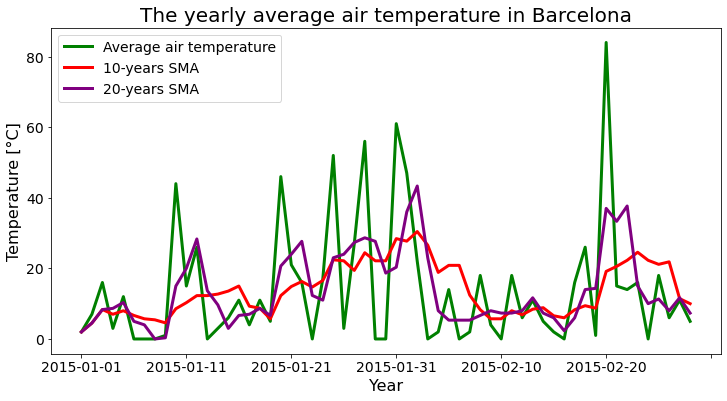

In [29]:
# colors for the line plot
colors = ['green', 'red', 'purple']

# line plot - the yearly average air temperature in Barcelona
df_temperature.plot(color=colors, linewidth=3, figsize=(12,6))

# modify ticks size
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.legend(labels =['Average air temperature', '10-years SMA', '20-years SMA'], fontsize=14)

# title and labels
plt.title('The yearly average air temperature in Barcelona', fontsize=20)
plt.xlabel('Year', fontsize=16)
plt.ylabel('Temperature [°C]', fontsize=16)

In [9]:
def creat_dataset(st_BPH=0, y_1='2015', y_2='2019', mode=1):
    for i in range(len(st_num)):
        st = i
        file_name = df_st['nameEng'][st_num[st]]
        name_input = file_name
        name_locals = 'stN_' + file_name

        # File name and Path
        csv_file = path_adress + name_input + '.csv'
        # index_col=0 , index_col=None
        dataset = pd.read_csv(csv_file, header=0,
                              index_col=0, encoding="TIS-620")
        dataset = dataset.drop(['address'], axis=1)
        dataset = dataset.drop(['year'], axis=1)
        dataset = dataset.drop(['dew'], axis=1)
        # dataset = dataset.drop(['latitude'], axis=1)
        # dataset = dataset.drop(['longitude'], axis=1)
        dataset.columns
        locals()[name_locals] = dataset
        # print(f'Dataframe name_station: {st+1 , name_input}')
        print('wait......')
        del dataset
        clear_output(wait=True)

    date_start = y_1 + '-01' + '-01'
    date_stop = y_2 + '-12' + '-31'

#---------------------------------------------------------------------------------------------------------------------------------------------------#
    if mode == 0:
        file_name = df_st['nameEng'][st_BPH]
        locals_input = 'stN_' + file_name
        print(locals_input)
        dataset_st = locals()[locals_input].loc[date_start:date_stop]
        frames_st = dataset_st
    else:
        m = 0
        for j in range(len(st_num)):
            # for j in range(df_st.shape[0]):
            # file_name = df_st['nameEng'][j]
            file_name = df_st['nameEng'][st_num[j]]
            locals_input = 'stN_' + file_name
            print(locals_input)
            dataset_st = locals()[locals_input].loc[date_start:date_stop]
            clear_output(wait=True)
            if m == 0:
                frames_st = dataset_st
                m = m+1
                print(m)
            else:
                frames_st = [frames_st, dataset_st]
                frames_st = pd.concat(frames_st)
#---------------------------------------------------------------------------------------------------------------------------------------------------#
    # frames=frames_st[new_colum_2]
    frames = frames_st
    return frames


In [10]:
frames_train = creat_dataset(1,'2015','2015',0)

stN_Chai Nat Rice research Center


In [11]:
frames_train

,latitude,longitude,day,month,mirid bug,mint,maxt,temp,humidity,wspd,...,R-12,R-13,R-14,R-15,R-16,R-17,R-18,R-19,R-20,bph
date,,,,,,,,,,,,,,,,,,,,,
2015-01-01,15.198,100.137,1,1,0,24.8,28.9,27.1,33.32,35.6,...,0,0,27787,218,576,550,1004,12125,1576,0
2015-01-02,15.198,100.137,2,1,0,21.2,27.2,24.2,43.19,21.6,...,0,0,27787,218,576,550,1004,12125,1576,1
2015-01-03,15.198,100.137,3,1,0,23.7,29.9,27.4,44.43,10.7,...,0,0,27787,218,576,550,1004,12125,1576,3
2015-01-04,15.198,100.137,4,1,0,25.9,30.1,28.0,45.44,8.8,...,0,0,27787,218,576,550,1004,12125,1576,104
2015-01-05,15.198,100.137,5,1,0,26.7,26.7,26.7,58.27,0.0,...,0,0,27787,218,576,550,1004,12125,1576,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2015-12-27,15.198,100.137,27,12,0,30.0,32.5,31.3,54.53,17.6,...,0,0,42092,331,873,833,1521,18368,2388,6
2015-12-28,15.198,100.137,28,12,2,29.5,33.5,31.9,59.08,3.7,...,0,0,42092,331,873,833,1521,18368,2388,16
2015-12-29,15.198,100.137,29,12,1,28.1,32.2,30.1,54.43,9.0,...,0,0,42092,331,873,833,1521,18368,2388,16
